# Demonstration of a GAP Range Map Evaluation Framework
This notebook details a framework for evaluating GAP range maps with occurrence data retrieved from databases such as GBIF via APIs.  It details the major steps and features of the framework for a single species: the yellow-billed cuckoo.  The primary results are some maps for visualization, columns added to a GAP range data .csv file that is downloaded from ScienceBase, and documentation of decisions and archiving of data used. 

See the README.md file in this repository for more information.

There are a few major steps:  

### 1. Range Evaluation Parameter Database
This process requires some decision making about how to filter the records and other things.  Such decisions are documented in a database that can be queried in the other steps and referred to later for reference.

### 2. Species Concepts
Taxonomic classifications are periodically revised,  creating the potential for disagreement among organizations/efforts/databases about what a species name actually refers to.  That disagreement needs to be assessed and resolved before retrievals of occurrence records can be fully trusted.

### 3. Retrieve and Filter Species Occurrence Records
Occurrence records can be accessed through API's, filtered, and saved in a database.  Filtering can happen during the request for records or after they have been received, but occur before the records are stored in a local database in this framework.  The precision of occurrence records varies due to coordinate uncertainty and detection distances, so points must be represented as circles (i.e., buffered)

### 4. Evaluate GAP Known Range Data
GAP ranges exist in table form in a database and on ScienceBase.  Ranges can be compared to occurrence circles to find HUCs where GAP was correct about species' presence and where it was wrong about absence.  The results of those comparisons can be saved in columns in the range tables.

### BONUS -- Automated Range Delineation
The occurrence record database populated for range evaluation could also be a source for range delineation: either by an expert or with an automated process.  Spatialite has a concave hull function that can be deployed.  I generated seasonal, yearly, and monthly range maps with that process, but they were of poor quality. 

### General Setup
Some parameters need to be declared, including a unique name for this evaluation.  

In [1]:
%matplotlib inline
import sqlite3
import pprint
import pandas as pd
#import geopandas as gpd
pd.set_option('display.width', 600)
pd.set_option('display.max_colwidth', 60)
pd.set_option('display.max_rows', 100)
from IPython.display import Image
import config

gap_id = 'bybcux'
inDir = '/users/nmtarr/documents/ranges/inputs/'
outDir = '/users/nmtarr/documents/ranges/outputs/'
summary_name = 'cuckoo' # an short, memorable name to use for file names etc.
years = '1970-2018'
eval_id = 'eval_gbif1'

## 1. Range Evaluation Parameter Database

Descriptions of all the columns in the databse are listed below.  As more filtering parameters are explored and employed for each data source, they will need to be described.  The database is currently stored locally but would eventually need to be on a server.

The database description and schema is printed below.

In [2]:
conn = sqlite3.connect('/users/nmtarr/documents/ranges/inputs/rng_eval_params.sqlite')
cursor = conn.cursor()
table_names = cursor.execute("SELECT DISTINCT table_name FROM column_descriptions;").fetchall()
for table in table_names:
    table = table[0]
    tbl_desc = cursor.execute("SELECT description FROM table_descriptions WHERE table_name='{0}';".format(table)).fetchone()
    print("\n","-"*80,"\n\n",table.upper(),"TABLE\n",str(tbl_desc[0]),"\n")
    print(" COLUMNS")
    print(" Id, Column Name, Data Type, Not Null, Default, Unique")
    pprint.pprint(cursor.execute("PRAGMA table_info('{0}');".format(table)).fetchall())
    df = cursor.execute("SELECT * FROM column_descriptions WHERE table_name='{0}'".format(table)).fetchall()
    for row in df:
        print('\n' + row[1] + ' -- ' + row[2])


 -------------------------------------------------------------------------------- 

 GBIF_FILTERS TABLE
 Stores and documents filter sets applied after retrieving data. 

 COLUMNS
 Id, Column Name, Data Type, Not Null, Default, Unique
[(0, 'filter_id', 'TEXT', 1, None, 1),
 (1, 'has_coordinate_uncertainty', 'INTEGER', 0, None, 0),
 (2, 'creator', 'TEXT', 0, None, 0),
 (3, 'notes', 'TEXT', 0, None, 0)]

filter_id -- Unique id for a combination of filtering parameters. Make it unique across all other filters.

has_coordinate_uncertainty -- Should you remove records without coordinate uncertainty (1) or leave them in the data set (0).

creator -- Name of the person who created this filter set.

notes -- Detailed notes on the intent of the filter set (aside from what's obvious) and any specific strengths, weaknesses, or issues.

has_coord_why -- Reason for this filter setting.

 -------------------------------------------------------------------------------- 

 GBIF_REQUESTS TABLE
 Stores

## 2. Species Concepts
Species concepts of interest need to be matched up with concepts used by data sources.  The BCB's Taxa Information Registry can likely facilitate this in the future.  The species concept lists used here will be saved in the rng_eval_param database.  For development purposes, I have manually entered one species but this step can be developed more fully later.

Note the field for species geometry that could be used to apply a spatial filter to records that would exclude records that are in far-off or impossible locations.

In [3]:
#%run 'id_species_concepts.py'

In [4]:
vals = cursor.execute("SELECT * FROM species_concepts;").fetchall()[0]
cols = [x[1] for x in cursor.execute("PRAGMA table_info('species_concepts')").fetchall()]
pprint.pprint(dict(zip(cols, vals)))

{'bcb_id': None,
 'breeding_months': '4,5,6,7,8',
 'common_name': 'yellow-billed cuckoo',
 'detection_distance_meters': 200,
 'end_year': None,
 'error_tolerance': 40,
 'fws_id': None,
 'gap_id': 'bybcux',
 'gbif_id': '2496287',
 'geometry': None,
 'itis_tsn': '177831',
 'migratory': '1',
 'notes': 'Manually entered for use in development. ',
 'pad': 2,
 'scientific_name': 'Coccyzus americanus',
 'species_id': 'bybcux0',
 'start_year': None,
 'wintering_months': '11,12,1,2'}


# 3. Retrieve and Filter Occurrence Data
Data can be retrieved through APIs, but it needs to be filtered.  Many options for filtering exist and are data source specific, so decisions have to be made about how to filter.  In this framework, I am proposing that filters be treated as unique entities (__filter sets__) that are stored and documented in the rng_eval_params database.  Doing so provides a way to link data sets used for range evaluation (or delineation) back to the decisions made when aquiring them.  Filter sets would be documented in tables specific to the data source and step of filtering; so far, gbif_requests and gbif_filters are such tables.  This example is using filter sets __'r001'__ (request filter) and __'f001'__ (post-request filter).  

In [5]:
df1 = pd.read_sql_query(sql="SELECT * FROM gbif_requests", con=conn)
print("REQUEST FILTER SET")
print(df1.loc[0])

REQUEST FILTER SET
request_id                                   r001
lat_range                                   27,41
lon_range                                 -91,-75
years_range                             1970,2018
months_range                                 1,12
geoissue                                    False
coordinate_issue                             True
continent                           north_america
creator                                   N. Tarr
notes               Used during code development.
Name: 0, dtype: object


In [6]:
df2 = pd.read_sql_query(sql="SELECT * FROM gbif_filters", con=conn)
print("POST REQUEST FILTER SET")
print(df2.loc[0])

POST REQUEST FILTER SET
filter_id                                      f001
has_coordinate_uncertainty                        1
creator                                     N. Tarr
notes                         Used for development.
Name: 0, dtype: object


In [7]:
# Run a script that retrieves and filters
#%run 'retrieve_occurrences.py'

At this point, records have been retrieved, filtered, buffered, and stored in a database.  They are displayed below on a map with the GAP range map.

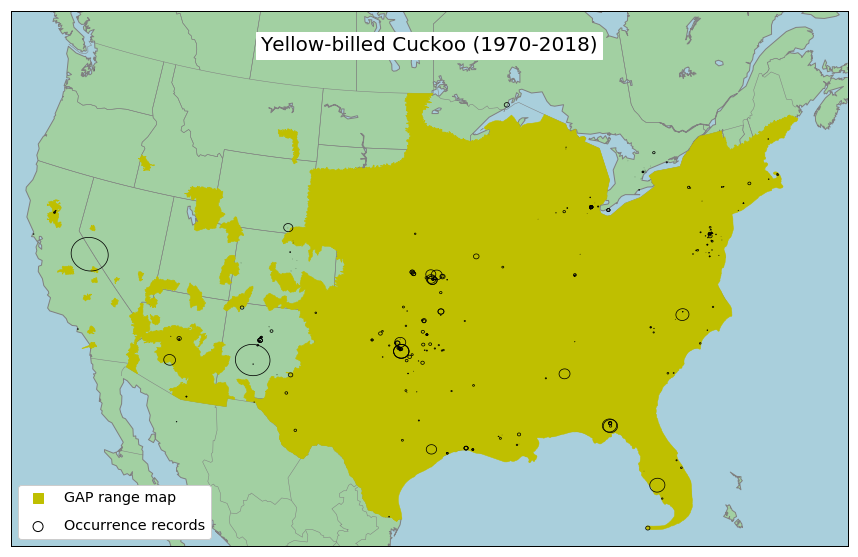

In [8]:
gap_range2 = "{0}{1}_range_4326".format(inDir, gap_id)

shp1 = {'file': gap_range2, 'column': None, 'alias': 'GAP range map',
        'drawbounds': False, 'linewidth': .5, 'linecolor': 'y',
        'fillcolor': 'y', 'marker':'s'}

shp2 = {'file': '{0}{1}_circles'.format(outDir, summary_name), 'column': None,
        'alias': 'Occurrence records', 'drawbounds': True, 'linewidth': .75, 'linecolor': 'k',
        'fillcolor': None, 'marker':'o'}

# Display occurrence polygons
title="Yellow-billed Cuckoo ({0})".format(years)
config.MapShapefilePolygons(map_these=[shp1, shp2], title=title)

# 4. Evaluate GAP Known Range Data
The first step in using occurrence records to evaluate GAP range is to build another database to hold the GAP 12 digit HUCs and range for the species, as well as for performing the necessary spatial queries.  The GAP range is retrieved from ScienceBase and the HUCs would be too if they were available as a shapefile.  

In [9]:
#%run 'make_range_evaluation_db.py'

As with the filter sets, parameters for evaluation have to be set/decided upon.  I am proposing that evaluation parameter sets also be documented as unique entities in a database (i.e, rng_eval_params).  Each evaluation can be given a unique id that can be used in documentation, file naming, and for the names of the columns that will be added to the GAP range table to record the results of the evaluation.  In this example, the evaluation_id is __eval_gbif1__.  It's definition is printed below.

In [10]:
df3 = pd.read_sql_query(sql="SELECT * FROM evaluations WHERE evaluation_id = 'eval_gbif1'", con=conn)
print("EVALUATION PARAMETERS")
print(df3.loc[0])

EVALUATION PARAMETERS
evaluation_id                                                       eval_gbif1
species_id                                                             bybcux0
years              1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 19...
months                                              1,2,3,4,5,6,7,8,9,10,11,12
pad                                                                          2
error_tolerance                                                             40
method                                                   Proportion in polygon
filter_sets                                                         r001, f001
justification                                                     Experimental
creator                                                                N. Tarr
date                                                                 1/29/2019
notes              Used for development purposes.  Run when only GBIF recor...
Name: 0, dtype: object


Next, buffered occurrence point circles can be spatially compared against the HUC layer in order to determine which HUCs they can be attributed to.  After they are attributed to HUCs, the results can be recorded in the species' range map table in terms of whether the two data sets agreed and whether they validate the GAP range data for any HUCs.  

For each evaluation, a column is added for 1) how many records could be attributed to each huc and 2) whether there is agreement at that huc (1 for yes, 0 for no, 'None' for no data for that huc) and 3) whether the GAP range has been validated by the evaluation.

Evaluations are unique entities composed of filtered data and evaluation methods and parameters.  For this example, the method used was intersection with an error tolerance of 40% during the intersection.  That means that an occurrence was attributed to a HUC when > 60% of the occurrence circle occurred in the HUC.  The figure below illustrates how this plays out: circles are occurrence polygons, blue polygons are hucs, and numbers tell how many occurrences were attributed to the huc.  Note that that huc with 3 occurrences contains 3 small occurrence circles that are identical and therefore appear as one.  A "pad" is applied in the evaluation too so that HUCs with a number of occurrences > than the pad are considered to indicate agreement.  This is a way to mediate the influence of false positives and other sporadic errors.  Pads can be set at the species level or evaluation level.

The 'proportion in polygon method' illustrated


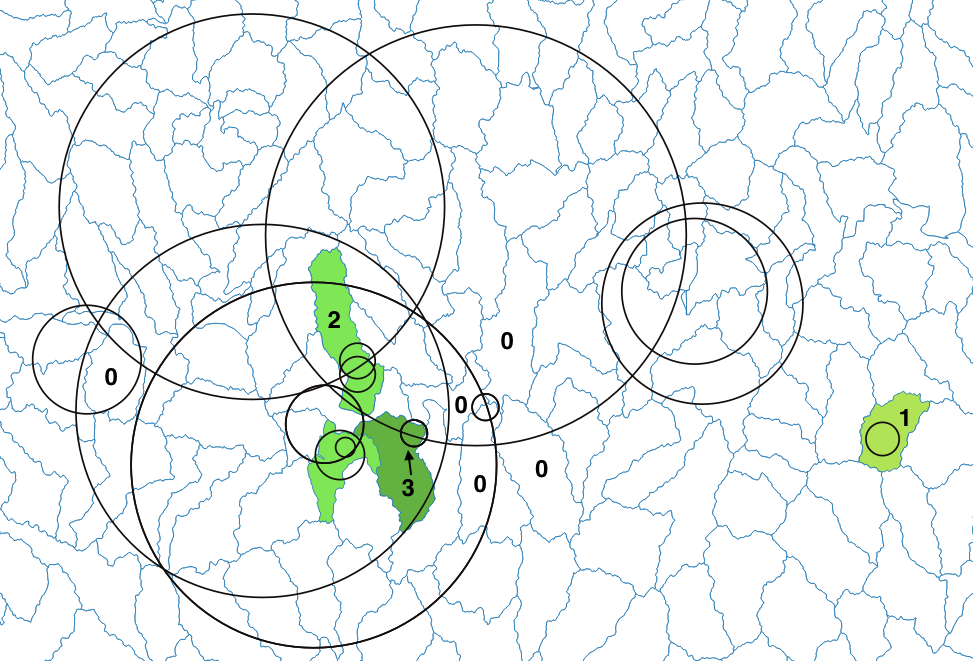

In [11]:
print("The 'proportion in polygon method' illustrated")
Image("/users/nmtarr/Documents/RANGES/Fig1.png")

In [12]:
#%run 'eval_gbif1.py'
connr = sqlite3.connect('/users/nmtarr/documents/ranges/outputs/bybcux_range.sqlite')
df4 = pd.read_sql_query(sql="SELECT strHUC12RNG AS HUC12RNG, "
                                    "intGAPOrigin AS Origin, intGAPPresence AS Presence, "
                                    "intGAPReproduction AS Reproduction,"
                                    "intGAPSeason AS Season, eval_gbif1_cnt, eval_gbif1, "
                                    "validated_presence AS validated_pres FROM new_range WHERE eval_gbif1_cnt >=0", con=connr)
df4.set_index(["HUC12RNG"], inplace=True)
print("Tabular results of the evaluation")
print(df4)

Tabular results of the evaluation
             Origin Presence Reproduction Season  eval_gbif1_cnt  eval_gbif1  validated_pres
HUC12RNG                                                                                    
020600060301      1        1            1      4               1         NaN               0
041402011009      1        1            1      4               1         NaN               0
040802030108      1        1            1      4               1         NaN               0
030501011401      1        1            1      4               2         1.0               1
102701040502      1        1            1      4               2         1.0               1
020200060907      1        1            1      4               2         1.0               1
102701040205      1        1            1      4               3         1.0               1
040900050403      1        1            1      4               1         NaN               0
180201570704      1        1        

Mapped results of the evaluation.


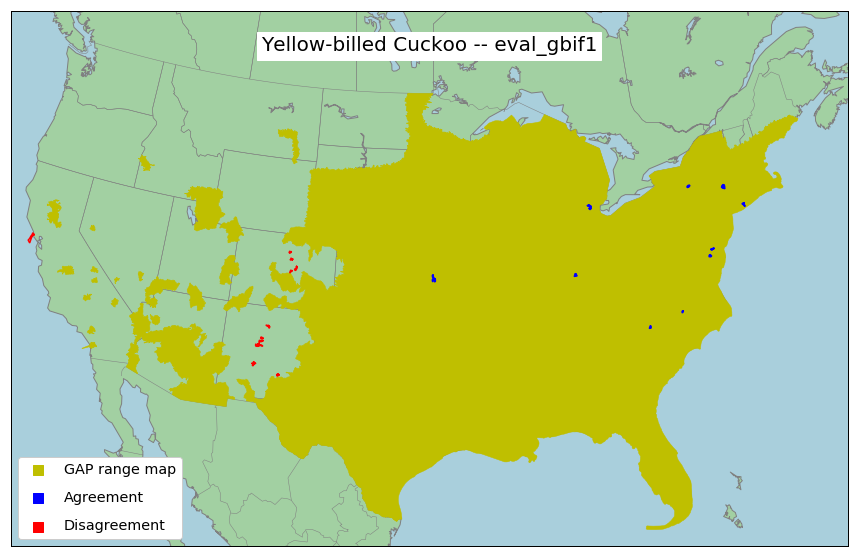

In [13]:
print("Mapped results of the evaluation.")
shp3 = {'file': '{0}{1}_eval_gbif1'.format(outDir, gap_id), 'column': 'eval_gbif1',
        'alias': 'eval_gbif1', 'column_colors': {1: 'b', 0: 'r'}, 
        'value_alias': {1:'Agreement', 0:'Disagreement'}, 'drawbounds': False, 
        'marker': "s"}
title="Yellow-billed Cuckoo -- eval_gbif1"
config.MapShapefilePolygons(map_these=[shp1, shp3], title=title)

# BONUS -- Automated Range Delineation
I generated yearly, monthly, and seasonal ranges for the yellow-billed cuckoo with spatialite's concave hull function.  Each map was stored as a record in a table (with geometry) within range evaluation database (for now).  Below is an example of a summer range map.  It does not appear useful but maybe the delineation method could be improved or integrating more occurrence records will improve it.

In [14]:
#%run 'make_range_polygons.py'

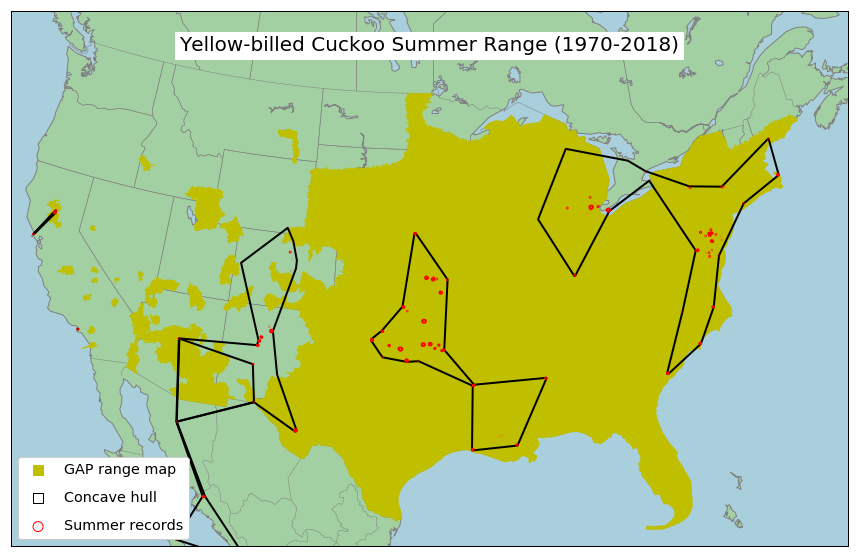

In [15]:
shp4 = {'file': '{0}summer_range'.format(outDir, gap_id), 'column': None,
        'alias': 'Concave hull', 'drawbounds': True, 'linewidth': 2., 'linecolor': 'k',
        'fillcolor': None, 'marker':'s'}

shp5 = {'file': '{0}summer_occs'.format(outDir, gap_id), 'column': None,
        'alias': 'Summer records', 'drawbounds': True, 'linewidth': 2., 'linecolor': 'r',
        'fillcolor': None, 'marker':'o'}

# Display occurrence polygons
title="Yellow-billed Cuckoo Summer Range ({0})".format(years)
config.MapShapefilePolygons(map_these=[shp1, shp4, shp5], title=title)

# Next Steps
This is just a starting point that needs scrutiny.  It is currently hard-coded for a single species, so deploying it would require redesigning to accomodate large numbers of species, multiple users, many more occurrence records, optimal methods for evaluation and range delineation among other things.  